In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM, GMMHMM, MultinomialHMM
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_ticker_df(symbol):
    return all_tickers_df.query(f"symbol == '{symbol}'").sort_values("datetime", ascending=True)

In [3]:
all_tickers_df = pd.read_csv('aapl_tsla_adbe_sample_data.csv')

In [4]:
aapl_symbol = 'AAPL'
adbe_symbol = 'ADBE'
tsla_symbol = 'TSLA'

aapl_df = get_ticker_df(aapl_symbol)
adbe_df = get_ticker_df(adbe_symbol)
tsla_df = get_ticker_df(tsla_symbol)

In [5]:
aapl_df.head(2)

,datetime,symbol,open,high,low,close,vol,return,return_x100,log_ma_7_return
0,2003-09-30,AAPL,0.3766,0.3790,0.3650,0.3700,285680192.0,-0.027340,-2.733964,-0.012403
1,2003-10-01,AAPL,0.3698,0.3768,0.3606,0.3713,237916000.0,0.003514,0.351351,-0.008683


In [6]:
adbe_df.head(2)

,datetime,symbol,open,high,low,close,vol,return,return_x100,log_ma_7_return
8740,2003-09-30,ADBE,19.885,19.975,19.33,19.695,11558724.0,-0.020149,-2.014925,-0.006957
8741,2003-10-01,ADBE,19.755,20.195,19.50,19.900,12774422.0,0.010409,1.040873,-0.000988


### Please see the below preprocess functions for how `returnx100` and `log_ma_7_return` are computed
```python
def prepare_data_for_model_input(sub_df, ma):
    prices = sub_df['close']
    moving_avg = prices.rolling(ma).mean()
    log_return = np.log(moving_avg / moving_avg.shift(1)).dropna()
    sub_df[f'log_ma_{ma}_return'] = log_return
    sub_df.dropna(inplace=True)
    
final_ticker_df_list = []
for sub_df in ticker_df_list:
    sub_df['return'] = sub_df['close'].pct_change()
    sub_df['return_x100'] = sub_df['return'] * 100
    prepare_data_for_model_input(sub_df, 7)
    final_ticker_df_list.append(sub_df)
```

In [7]:
def get_train_test_df(target_df):
    nrow = target_df.shape[0]
    n_train = int(nrow * 0.7)
    n_test = nrow - n_train
    train_df = target_df.head(n_train)
    test_df = target_df.tail(n_test)
    train_X = train_df[['log_ma_7_return']]
    test_X = test_df[['log_ma_7_return']]
    return train_df, train_X, test_df, test_X

def train_model(train_X):
    model = GaussianHMM(
        n_components=2, 
        covariance_type="diag", 
        n_iter=100000, 
        tol=0.01, 
        random_state=42
    )
    return model.fit(train_X)

def populate_results(model, train_df, train_X, test_df, test_X):
    train_df['state'] = model.predict(train_X)
    test_df['state'] = model.predict(test_X)

def get_palette(plot_df):
    palette = {}
    has_state = 'state' in plot_df.columns
    if not has_state:
        return None
    for k, gp_df in plot_df.groupby("state"):
        if gp_df['return_x100'].mean() > 0:
            palette[k] = "green"
        else:
            palette[k] = "red"
    return palette

def plot(symbol, plot_df, tail=None, save=False):
    plt.figure(figsize=(20,8))
    palette = get_palette(plot_df)
    if tail:
        plot_df = plot_df.tail(tail)
    has_state = 'state' in plot_df.columns
    hue = plot_df['state'] if has_state else None
    ax = sns.scatterplot(
        x=pd.to_datetime(plot_df.datetime), 
        y=plot_df['close'], 
        palette=palette, 
        hue=hue
    )
    ax.legend_.remove()
    plt.title(symbol)
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    if save:
        plt.savefig(f'test/{symbol}_hmm_test.png')
        
def main(symbol, target_df, save=False):
    train_df, train_X, test_df, test_X = get_train_test_df(target_df)
    model = train_model(train_X)
    populate_results(model, train_df, train_X, test_df, test_X)
    plot(symbol, test_df, tail=500, save=save)   
    

def choose_best_hmm(train_X, ns=[2, 3, 4, 5, 6], plot=False):
    n_to_model_dict = {}
    bic_dict = {}
    for n in ns:
        print(f"Training n = {n}")
        model = GaussianHMM(n, covariance_type="full", n_iter=100000, tol=0.01, random_state=42)
        model.fit(train_X)
        score = model.score(train_X)
        bic_dict[n] = model.bic(train_X)
        n_to_model_dict[n] = model
    chosen_n = min(bic_dict, key=bic_dict.get)
    print(f"Chosen n = {chosen_n}")
    if plot:
        plt.plot(ns, bic_dict.values(), label="BIC", color="green", marker="o")
    return n_to_model_dict[chosen_n]

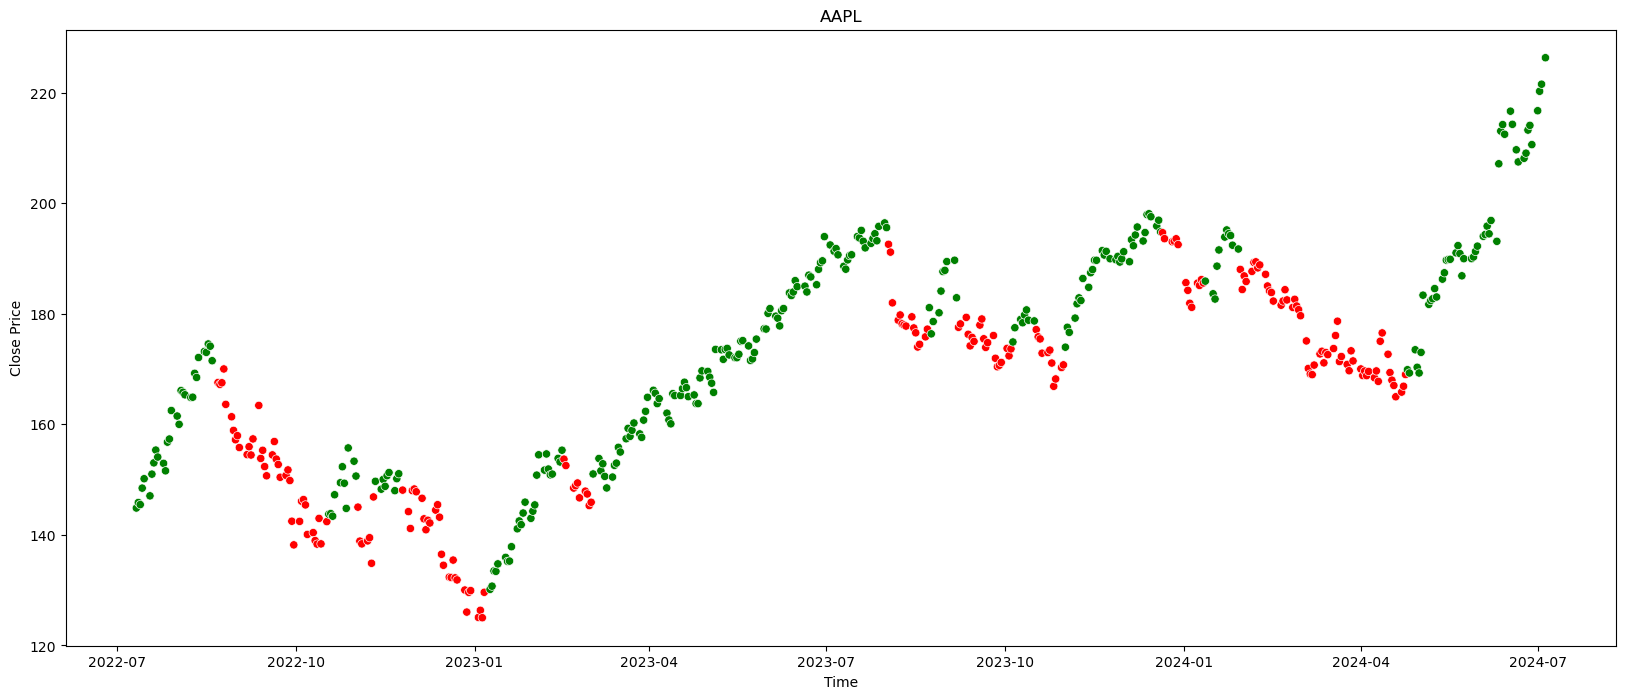

In [8]:
main("AAPL", aapl_df)

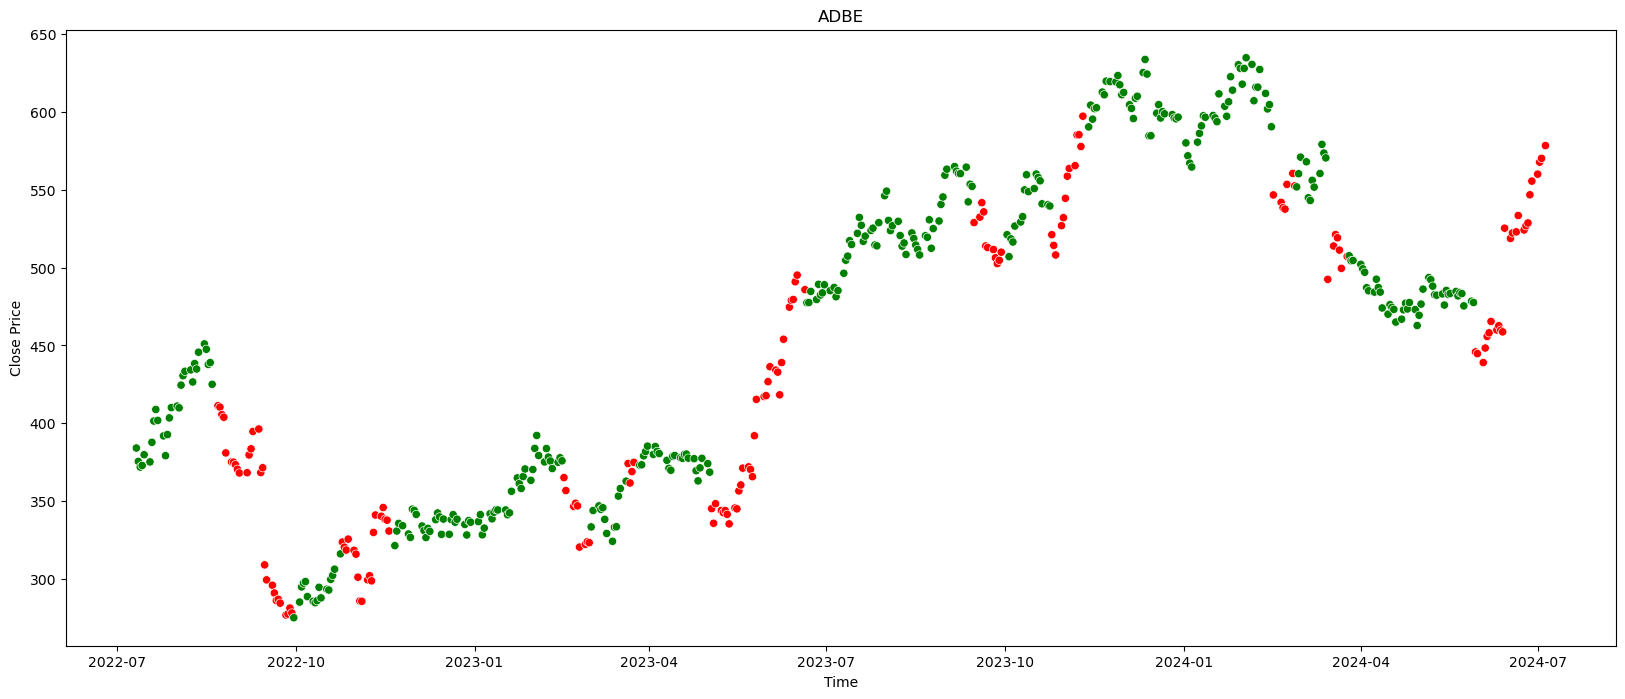

In [9]:
main("ADBE", adbe_df)

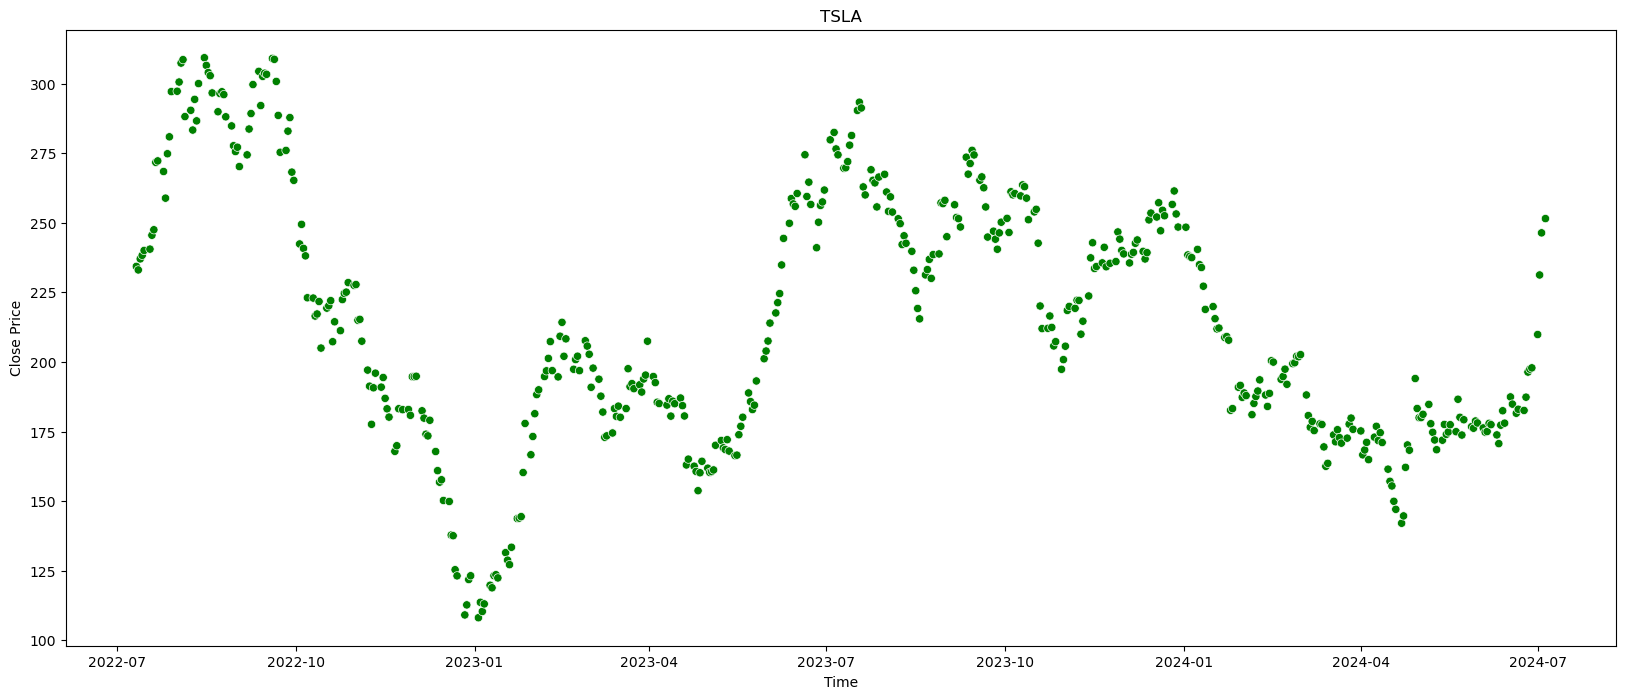

In [10]:
main("TSLA", tsla_df)